# Prediction Gain of Linear Prediction

This code is provided as supplementary material of the lecture "Coding of Audiovisual Signals".

This code illustrates
* Calculation of the prediction gain
* Playback of the prediction error signal
* Difference between blockwise adaptation and constant predictor coefficients

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shutil
from scipy.signal import lfilter
from scipy.io import wavfile
import scipy.signal as sp

import IPython.display as ipd
from pylab import rcParams
rcParams['axes.xmargin'] = 0

Consider two different wave files

In [2]:
def audio_load(filename, sr = None):
    old_sampling_rate, x = wavfile.read(filename)
    if len(x.shape) == 2:
        x = np.squeeze(x[:,0])
    x = x/32768
    if sr is not None:
        sampling_rate = sr
        number_of_samples = round(len(x) * sampling_rate / old_sampling_rate) 
        x = sp.resample(x, number_of_samples)
    else:
        sampling_rate = old_sampling_rate
    return x, sampling_rate

In [3]:
def audio_display_waveshow(y, sr, alpha = 0.8, color = 'skyblue', linewidth = 1):
    time = np.linspace(0, len(y) / sr, num=len(y))
    #plt.plot(time, y, color=color, alpha=alpha, linewidth=1)
    #plt.xlim(time[0], time[-1])
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.fill_between(time, -np.abs(y), np.abs(y), color='skyblue')
    plt.xlabel("Time")


In [4]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'

## First case: Fixed prediction coefficients
Calculate the prediction gain as
$$
G_{\mathsf{p}} = \frac{\sigma_x^2}{\sigma_x^2-\boldsymbol{\varphi}_{XX}^{\mathsf{T}}\boldsymbol{R}_{XX}^{-1}\boldsymbol{\varphi}_{XX}}
$$
where
$$
\boldsymbol{\varphi}_{XX} := \begin{pmatrix}
			\varphi_{XX}[1] \\
			\varphi_{XX}[2] \\			
			\vdots\\
			\varphi_{XX}[n]
			\end{pmatrix}
$$ 
and
$$
\boldsymbol{R}_{XX} := \begin{pmatrix}
			\varphi_{XX}[0] & \varphi_{XX}[-1] & \cdots & \varphi_{XX}[1-n] \\
			\varphi_{XX}[1] & \varphi_{XX}[0] & \cdots & \varphi_{XX}[2-n] \\
			\vdots & \vdots & \ddots & \vdots\\
			\varphi_{XX}[n-1] & \varphi_{XX}[n-2] & \cdots & \varphi_{XX}[0] \end{pmatrix}
$$
with 
$$
\varphi_{XX}[\lambda] = \mathbb{E}\left\{X[k]X[k-\lambda]\right\}
$$
being the auto-correlation of $X$.

In [5]:
# helper function calculating the correlation coefficient as defined in the lecture
def auto_correlation(x, k):
    if k >= 0:
        x_shift = np.roll(x,k)
        x_shift[:k] = 0
    else:
        x_shift = np.roll(x,k)
        x_shift[k:] = 0
        
    return np.correlate(x,x_shift)[0] / len(x)
    
# calculate prediction gain
def get_prediction_gain(x, n):
    if n == 0:
        return 1
    
    phi_XX = np.array([auto_correlation(x,k) for k in np.arange(1,n+1)])
    
    # inefficient way to calculate R_XX as many terms can be reused due to symmetric of the auto-correlation function
    R_XX = np.array([[auto_correlation(x,i-j) for j in range(n)] for i in range(n)])
    
    sigmaq_x = np.mean(np.square(x))    
    
    sigmaq_d = sigmaq_x - phi_XX.T @ np.linalg.inv(R_XX) @ phi_XX
    
    Gp = sigmaq_x / sigmaq_d
    return Gp

In [6]:
# compute prediction gains for two different audio files
x, sampling_rate = audio_load(wave_filename, sr = 8000)
    
n_range = range(31)
Gp = [get_prediction_gain(x,n) for n in n_range]

### Playback of prediction error signal

In [7]:
# select a prediction filter of 10 coefficients
n = 10

phi_XX = np.array([auto_correlation(x,k) for k in np.arange(1,n+1)])
    
# inefficient way to calculate R_XX as many terms can be reused due to symmetric of the auto-correlation function
R_XX = np.array([[auto_correlation(x,i-j) for j in range(n)] for i in range(n)])

# optimal prediction coefficients
aopt = np.linalg.inv(R_XX) @ phi_XX

# generate prediction signal
xh = lfilter(np.concatenate(([0], aopt)), 1, x)

# prediction error
d = x - xh

Playback original signal

In [8]:
# playback original audio
ipd.Audio(x, rate=sampling_rate)

Playback predicted signal

In [9]:
# playback original audio
ipd.Audio(xh, rate=sampling_rate)

Playback prediction error

In [10]:
# playback original audio
ipd.Audio(d, rate=sampling_rate)

Plot waveforms

<Figure size 1000x1100 with 0 Axes>

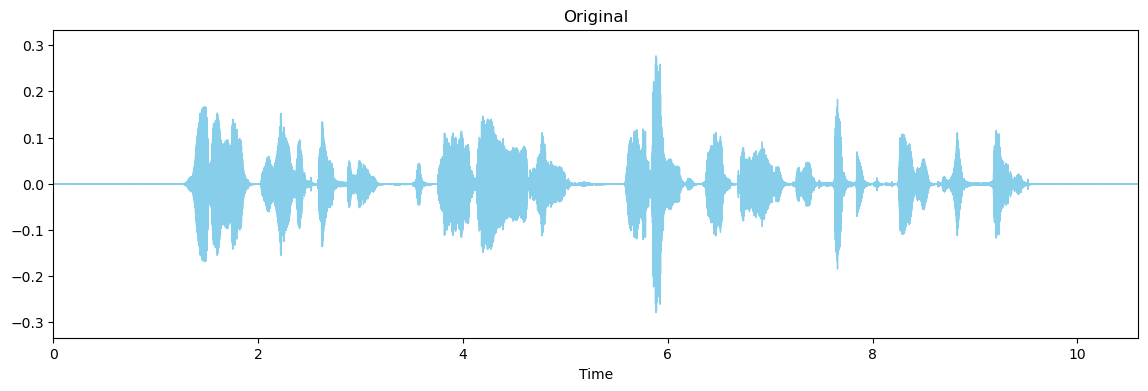

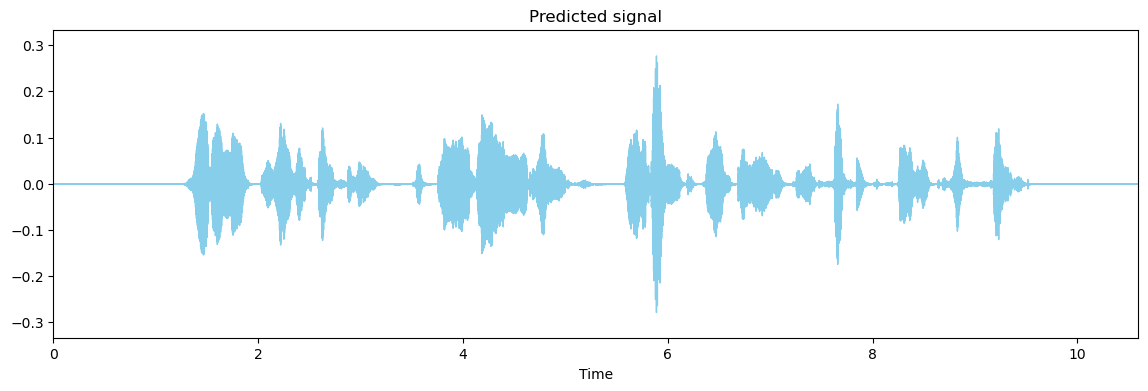

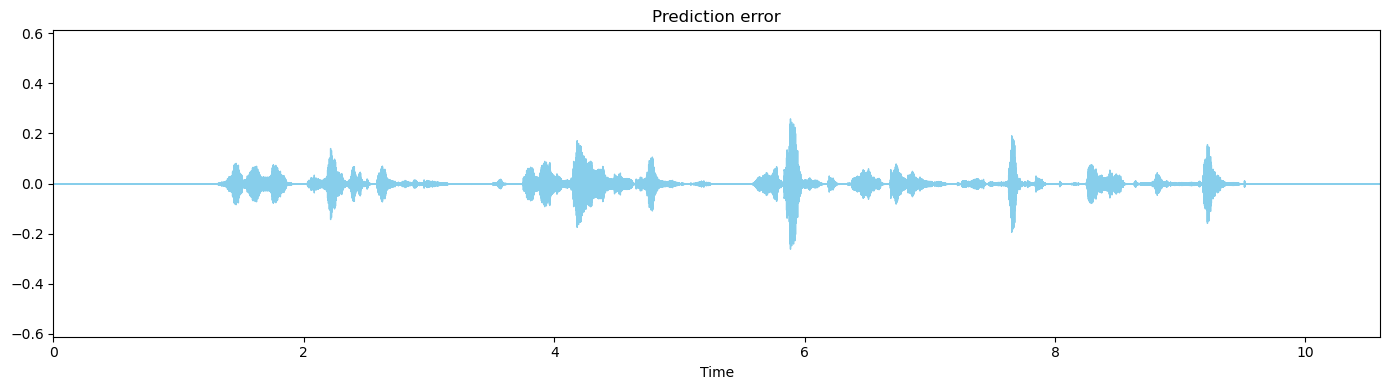

In [11]:
x_max = np.max([np.max(x), -np.min(x)])

plt.figure(figsize=(10, 11))
#plt.subplot(3,1,1)
audio_display_waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,2)
audio_display_waveshow(xh, sr=sampling_rate)
plt.title('Predicted signal')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,3)
audio_display_waveshow(d, sr=sampling_rate)
plt.title('Prediction error')
plt.ylim((-x_max*2.2,+x_max*2.2))
plt.tight_layout()

## Second case: Block adaptation of predictor coefficients

We extract blocks of the signal using a rectangular window $w[k]$ of length $N$
$$
			\tilde{x}[k] = x[k]\cdot w[k_0-k]
$$     
The signal $\tilde{x}[k]$ attains non-zero values only within the time interval
$$
			k_1 = k_0-N+1 \leq k \leq k_0
$$
The short-term auto-correlation for finite-energy signals is defined as ($\forall\lambda \in\{0,1,\ldots, n\}$)
$$
r_\lambda = \sum_{k=k_1}^{k_0}\tilde{x}[k]\tilde{x}[k+\lambda] = \sum_{k=k_1}^{k_0-\lambda}x[k]x[k+\lambda]
$$
Due to symmetry ($r_{-\lambda} = r_\lambda$), the normal equations can be rewritten as
$$
			\begin{pmatrix}
			r_1 \\
			r_2 \\
			r_2 \\
			\vdots \\
			r_n
			\end{pmatrix} = \begin{pmatrix}
			r_0 & r_1 & r_2 & \cdots & r_{n-1} \\
			r_1 & r_2 & r_3 & \cdots & r_{n-2} \\
			r_2 & r_3 & r_4 & \cdots & r_{n-3} \\			
			\vdots & \vdots & \vdots & \ddots & \vdots \\
			r_{n-1} & r_{n-2} & r_{n-3} & \cdots & r_{0} \\
			\end{pmatrix}\begin{pmatrix}
			a_1 \\
			a_2 \\
			a_3 \\
			\vdots \\
			a_n
			\end{pmatrix}
$$
The solution of this system yields optimal predictor coefficients $\boldsymbol{a}_{\text{opt}}$ for this block.

In [12]:
# helper function calculating the auto-correlation coefficient r
def get_r(x, l):    
    x_shift = np.roll(x,l)
    x_shift[:l] = 0        
    return np.correlate(x,x_shift)[0]
    
    
def get_prediction_coefficients(x, n):
    r = np.array([get_r(x,k) for k in np.arange(1,n+1)])
    R = np.array([np.concatenate(([get_r(x,j) for j in np.arange(i,0,-1)], [get_r(x,j) for j in np.arange(0,n-i)])) for i in range(n)])    
    
    a_opt = np.linalg.inv(R) @ r
    return a_opt

In [13]:
# block prediction with N samples per block and predictor order n
def block_prediction(x, n, N):
    if n==0:
        return x
    
    frames = int(np.floor(len(x) / N))

    # prediction error
    d = np.zeros_like(x)

    # no adaptation for first frame
    a = np.zeros(n)

    # filter memory
    memory = np.zeros(n)

    for k0 in range(frames):
        x_part = x[np.arange(N)+k0*N]

        # compute prediction coefficients on current block
        a = get_prediction_coefficients(x_part, n)               
        
        xh_part, memory = lfilter(np.concatenate(([0], a)), 1, x_part, zi=memory)
        d[np.arange(len(xh_part)) + k0*N] = x_part - xh_part
        

    return d    

In [14]:
# compute prediction gains for two different audio files, 20 ms blocks
N = int(sampling_rate * 0.02)

Gp_block = []
for n in n_range:
    d = block_prediction(x, n, N)        
    Gp_block.append(np.mean(np.square(x)) / np.mean(np.square(d)))

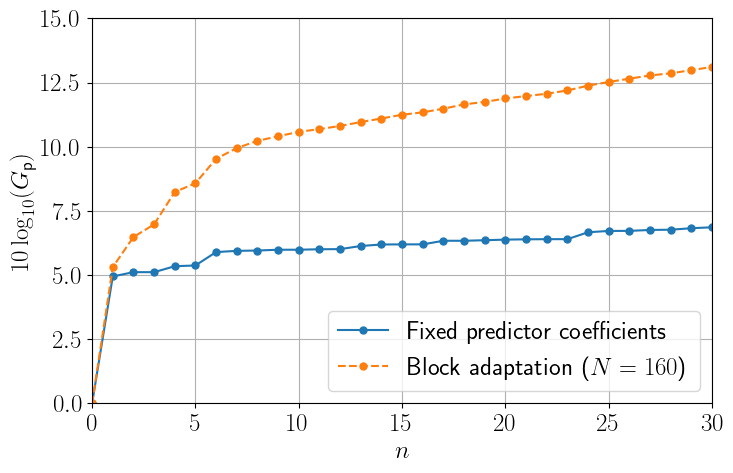

In [15]:
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)
plt.figure(figsize=(8, 5))

plt.plot(n_range, 10*np.log10(Gp), ms=5, marker='o')

plt.plot(n_range, 10*np.log10(Gp_block), '--',ms=5, marker='o')

    
plt.xlim((0,30))
plt.ylim((0,15))
plt.xlabel('$n$')
plt.grid(True)
plt.ylabel(r'$10\log_{10}(G_{\mathsf{p}})$')
plt.legend(['Fixed predictor coefficients', 'Block adaptation ($N=%d$)' % N], loc=4)         
#plt.savefig('figure_DST_6.11.pdf',bbox_inches='tight')

Generate prediction error and predicted signal

In [16]:
n = 30
d = block_prediction(x, n, N)    
xh = x-d

Playback original signal

In [17]:
ipd.Audio(x, rate=sampling_rate)

Playback predicted signal

In [18]:
ipd.Audio(xh, rate=sampling_rate)

Playback prediction error

In [19]:
ipd.Audio(d, rate=sampling_rate)

Plot waveforms

<Figure size 1000x1100 with 0 Axes>

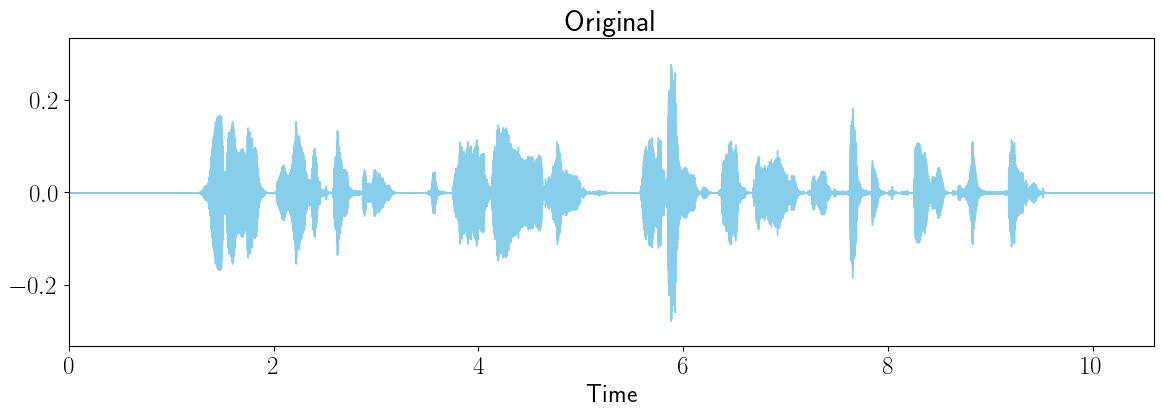

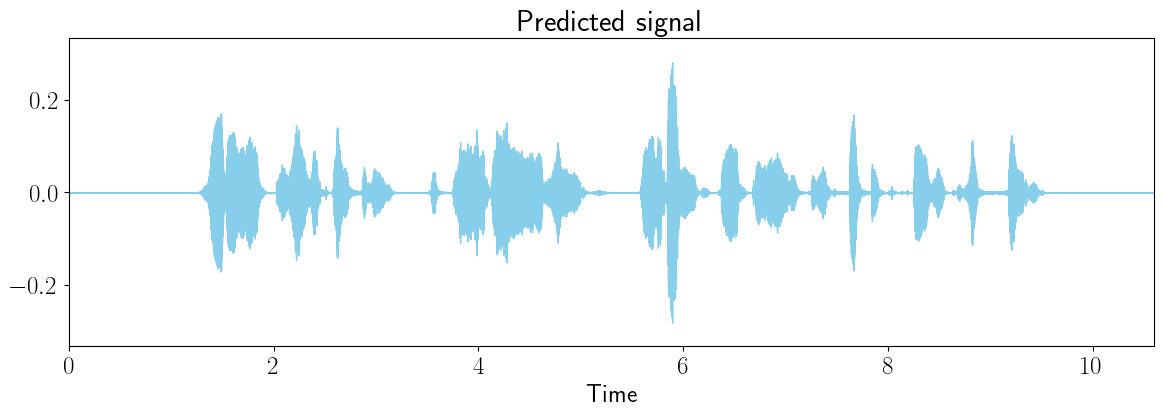

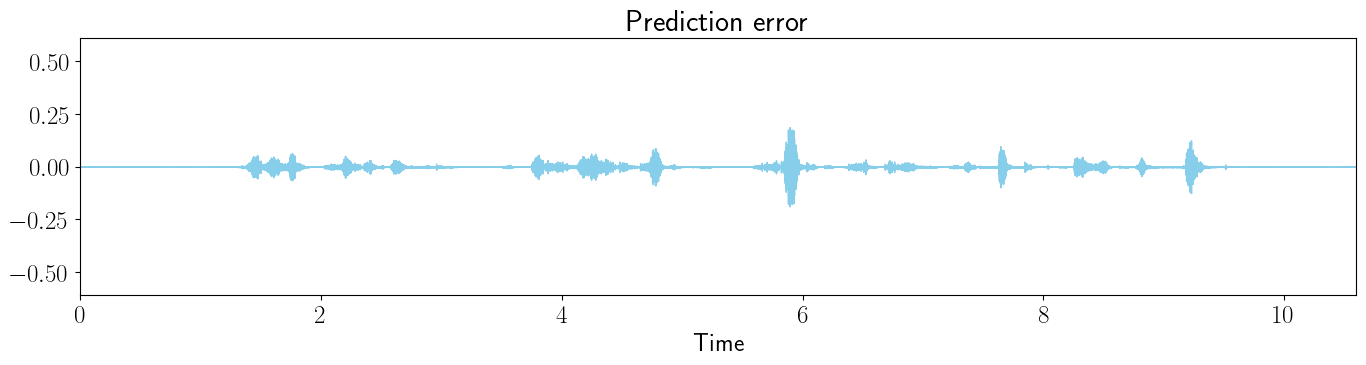

In [20]:
x_max = np.max([np.max(x), -np.min(x)])

plt.figure(figsize=(10, 11))
#plt.subplot(3,1,1)
audio_display_waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,2)
audio_display_waveshow(xh, sr=sampling_rate)
plt.title('Predicted signal')
plt.ylim((-x_max*1.2,+x_max*1.2))
#plt.subplot(3,1,3)
audio_display_waveshow(d, sr=sampling_rate)
plt.title('Prediction error')
plt.ylim((-x_max*2.2,+x_max*2.2))
plt.tight_layout()